# Predição da Qualidade de Vinhos Portugueses

Neste estudo vamos analisar algumas propriedades químicas de amostras de vinhos portugueses <br>
Nosso objetivo é identificar a viabilidade da criação de um modelo preditivo, <br>
que seja capaz de classificar vinhos por nível de qualidade.

### Starting out - Aqui algumas bibliotecas necessárias para nossa análise

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
sns.set_style('whitegrid')

#%matplotlib inline

### Loading & Shooting - Hora de carregar os dados em um Dataframe

In [2]:
df_wine = pd.read_csv("data/winequality.csv", sep=";")
df_size = len(df_wine)
print("Tamanho do Dataset:", df_size)
df_wine.head()

Tamanho do Dataset: 6497


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Olhando superficialmente o dataset vemos que se tratam de dados dados estruturados, as features são númericas com ponto flutuante, sendo apenas a coluna **type** do tipo **categórica**, vamos tratar dela mais a frente. 

### EDA - Exploratory Data Analysis

Antes de criarmos um modelo de predição precisamos explorar um pouco mais os dados que temos, é importante entender qual a distribuição das amostras de acordo com a feature target (ŷ) que pretendemos prever, além de identificar eventuais campos nulos que deverão ser tratados.

#### 1- Vamos verificar quantas amostras temos para cada nível de qualidade:

In [3]:
pd.DataFrame(df_wine["quality"]).groupby("quality")["quality"].aggregate(["count"]).sort_values("count", ascending=False)

,count
quality,
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


Nossas amostras apresentam níveis de qualidade que vão de 3 à 9. No mundo real os dados quase nunca são balanceados, neste caso não é diferente. Para vinhos de qualidade mínima (**3**) temos apenas **30** amostras.  Vinhos de nota máxima (**9**) são 5 únicas amostras dentre outras 6497, ou seja, uma representatividade amostral muito irrisória.

In [5]:
print("Percentual de Amostras de Qualidade 6: {0:.2f}%".format((2836/df_size)*100))

Percentual de Amostras de Qualidade 6: 43.65%


A maior parte dos dados (cerca de **93%** das amostras) são sobre vinhos medianos (**5,6,7**). Nesse cenário uma simples função que faça ŷ = 6 acertaria 43,6% dos casos. Portanto veremos que acurácia não será a melhor forma de avaliar um modelo de predição para esse dataset.

#### 2 - Plotting to see better - Uma histograma pode falar melhor sobre onde se concentram nossos dados

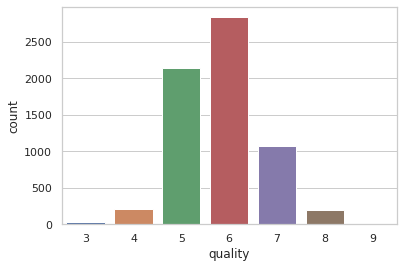

In [32]:
sns.countplot(data=df_wine, x="quality")
plt.show()

Acima podemos ver que inclusive a maior concentração de amostras está entre os vinhos de qualidade 5 e 6. O que acontece se também analisarmos se o vinho é branco ou vermelho?

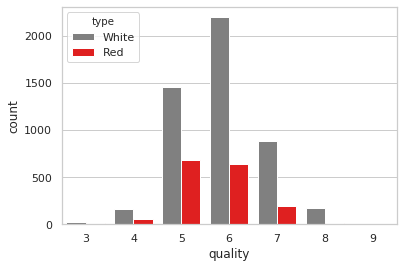

In [33]:
sns.countplot(data=df_wine, x="quality", hue="type", palette=['grey', 'red'])
plt.show()